In [1]:
import numpy as np
import pandas as pd
import random
import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns 
import yaml
from pathlib import Path
import sys 
import os 
sys.path.append(os.path.dirname(os.getcwd()))
from util.functions import logistic
from structure_generation.path_connection_gen import ProceduralGraphGenerator, StatsUtils, GraphStructureGenerator




In [2]:
geometric_graph_conf = yaml.safe_load(Path('config.yml').read_text())['reachability']

In [3]:
import multiprocessing, itertools
from typing import Union, Optional, Tuple, List
import networkx as nx 

In [20]:
def run_single_simulation(
    passed_inputs, 
    verbose : bool =  False 
    ):
    """
    Function to run one iteration of the simulation. Need to pass a list instead of arguments to function 
    is so that it can work with pmap.unordered
    """
    mean_degree, structure_name, number_nodes = passed_inputs
    results_dict_irreversable, results_dict_reversable = {}, {}
    if verbose: 
        print(f"simulation run for degree {mean_degree}")
    graphgen = GraphStructureGenerator(
        structure_name=structure_name, 
        num_nodes=number_nodes, 
        target_mean_degree = mean_degree
    )
    graph = graphgen.initial_graph  

    x = ProceduralGraphGenerator(graph)
    infection_matrix_list_irreversable, timesteps_saturation_irreversable, fraction_infected_list_irreversable, info_dict_irreversable = x.infect_till_saturation(
        structure_name = structure_name, modality="irreversable", verbose= False
    )
    infection_matrix_list_reversable, timesteps_saturation_reversable, fraction_infected_list_reversable, info_dict_reversable = x.infect_till_saturation(
        structure_name = structure_name, modality="reversable", verbose= False
    )
    results_dict_irreversable["infection_matrix"] = infection_matrix_list_irreversable
    results_dict_irreversable["timesteps_saturation"] = timesteps_saturation_irreversable
    results_dict_irreversable["fraction_infected_list"] = fraction_infected_list_irreversable
    results_dict_irreversable["info_dict"] = info_dict_irreversable

    results_dict_reversable["infection_matrix"] = infection_matrix_list_reversable
    results_dict_reversable["timesteps_saturation"] = timesteps_saturation_reversable
    results_dict_reversable["fraction_infected_list"] = fraction_infected_list_reversable
    results_dict_reversable["info_dict"] = info_dict_reversable

    return results_dict_reversable, results_dict_irreversable
    
def run_simulation(mean_degree : int, structure_name : str) -> list: 
    simulation_run_reversable, simulation_run_irreversable = [], []
    with multiprocessing.Pool(processes=multiprocessing.cpu_count() * 2 - 1) as p:
        iterThis = itertools.repeat(
            [
                mean_degree, 
                structure_name,
                geometric_graph_conf['nodes']
            ],
            geometric_graph_conf['num_simulation_runs'],
        )
        with tqdm.tqdm(total=geometric_graph_conf['num_simulation_runs']) as pbar:
            for _ in p.imap_unordered(run_single_simulation, iterThis):
                pbar.update()
                simulation_run_reversable.append(_[0])
                simulation_run_irreversable.append(_[1])

    final_dict_reversable = {k : [] for k in list(_[0].keys())}
    for key in final_dict_reversable.keys():
        for simulation_dict in simulation_run_reversable: 
            final_dict_reversable[key].append(simulation_dict[key])

    final_dict_irreversable = {k : [] for k in list(_[0].keys())}
    for key in final_dict_irreversable.keys():
        for simulation_dict in simulation_run_irreversable: 
            final_dict_irreversable[key].append(simulation_dict[key])

    return final_dict_reversable, final_dict_irreversable


def plot_results(results_dict : dict, structure_name : str ):
    for iter in results_dict['fraction_infected_list']:
        #print(iter['info_dict'])
        timesteps_list = [x for x in range(len(iter))]
        #try:
        #    p, cov = curve_fit(logistic, timesteps_list, iter)
        #    logistic_curve_data = logistic(timesteps_list, *p)
        #except:
        #    pass
        plt.plot(timesteps_list, iter, )#label = f"average simulated saturation across {len(result['timesteps_saturation'])} runs")
    #plt.plot(timesteps_list, logistic_curve_data, label = "fitted logistic")
    plt.title(
        f"saturation curve for {structure_name}     modality: {results_dict['info_dict'][0]['modality']}    mean degree: {round(results_dict['info_dict'][0]['average_degree'], 2)}")
    
    plt.xlabel("number simulation timesteps")
    plt.ylabel("fraction of giant graph infected")
    plt.legend()
    plt.show()

REVERSABLE GEOMETRIC GRAPH SIMULATION

simulation run for mean degree 5


100%|██████████| 30/30 [00:34<00:00,  1.15s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[{'average_degree': 5.887640449438202, 'num_nodes': 89, 'modality': 'reversable', 'degree_list': [3, 10, 6, 8, 5, 3, 5, 1, 7, 3, 7, 7, 6, 2, 7, 2, 12, 3, 10, 8, 5, 2, 6, 8, 3, 7, 10, 6, 8, 5, 4, 4, 6, 6, 6, 9, 1, 7, 10, 7, 10, 8, 3, 4, 3, 5, 10, 8, 6, 3, 10, 7, 3, 3, 7, 9, 9, 8, 10, 3, 2, 12, 10, 5, 7, 6, 5, 7, 3, 9, 12, 2, 2, 4, 9, 3, 3, 3, 4, 7, 9, 3, 3, 3, 5, 6, 3, 8, 5], 'clustering_coefficient': 0.5817038766476971, 'degree_assortivity': 0.6446925608076908, 'mean_shortest_pathlength': 5.5153217568947905}, {'average_degree': 5.0, 'num_nodes': 42, 'modality': 'reversable', 'degree_list': [10, 6, 4, 3, 2, 5, 7, 5, 6, 5, 6, 6, 3, 2, 6, 1, 4, 2, 5, 5, 4, 7, 10, 1, 3, 7, 3, 8, 5, 1, 5, 9, 6, 6, 3, 4, 7, 8, 1, 4, 9, 6], 'clustering_coefficient': 0.5662887377173093, 'degree_assortivity': 0.5530239099859353, 'mean_shortest_pathlength': 5.0580720092915215}, {'average_degree': 5.387755102040816, 'num_nodes': 49, 'modality': 'reversable', 'degree_list': [7, 7, 6, 8, 7, 8, 6, 5, 7, 1, 6, 4, 2, 

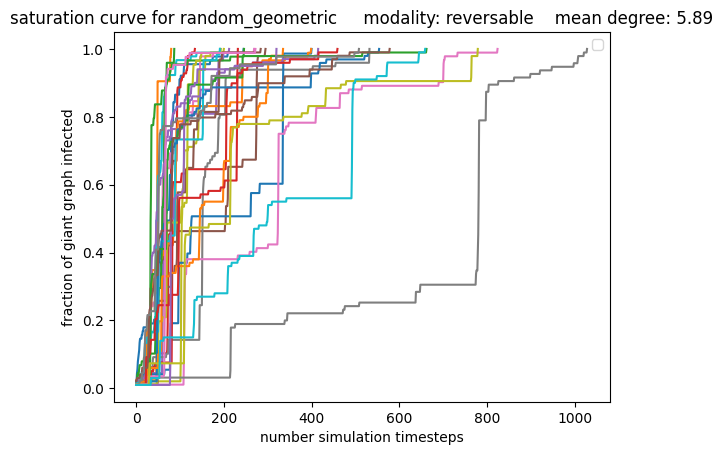

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[{'average_degree': 5.887640449438202, 'num_nodes': 89, 'modality': 'irreversable', 'degree_list': [3, 10, 6, 8, 5, 3, 5, 1, 7, 3, 7, 7, 6, 2, 7, 2, 12, 3, 10, 8, 5, 2, 6, 8, 3, 7, 10, 6, 8, 5, 4, 4, 6, 6, 6, 9, 1, 7, 10, 7, 10, 8, 3, 4, 3, 5, 10, 8, 6, 3, 10, 7, 3, 3, 7, 9, 9, 8, 10, 3, 2, 12, 10, 5, 7, 6, 5, 7, 3, 9, 12, 2, 2, 4, 9, 3, 3, 3, 4, 7, 9, 3, 3, 3, 5, 6, 3, 8, 5], 'clustering_coefficient': 0.5817038766476971, 'degree_assortivity': 0.6446925608076908, 'mean_shortest_pathlength': 5.5153217568947905}, {'average_degree': 5.0, 'num_nodes': 42, 'modality': 'irreversable', 'degree_list': [10, 6, 4, 3, 2, 5, 7, 5, 6, 5, 6, 6, 3, 2, 6, 1, 4, 2, 5, 5, 4, 7, 10, 1, 3, 7, 3, 8, 5, 1, 5, 9, 6, 6, 3, 4, 7, 8, 1, 4, 9, 6], 'clustering_coefficient': 0.5662887377173093, 'degree_assortivity': 0.5530239099859353, 'mean_shortest_pathlength': 5.0580720092915215}, {'average_degree': 5.387755102040816, 'num_nodes': 49, 'modality': 'irreversable', 'degree_list': [7, 7, 6, 8, 7, 8, 6, 5, 7, 1, 6, 

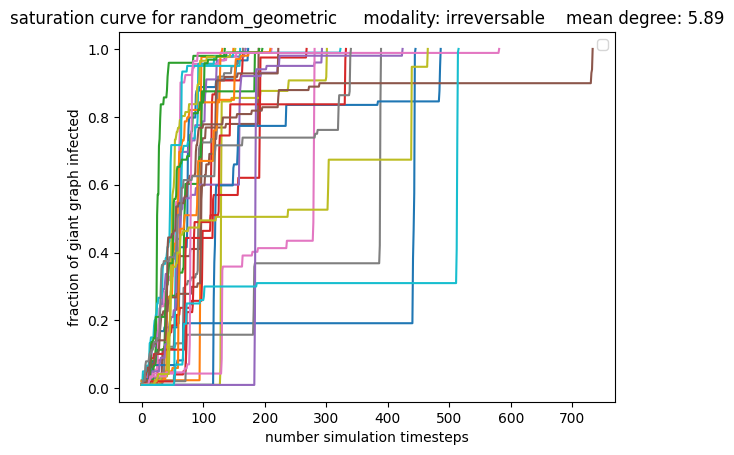

In [21]:
graph_name = "random_geometric"
for degree in geometric_graph_conf['mean_degrees']: 
    print(f"simulation run for mean degree {degree}")
    simulation_run = run_simulation(degree, graph_name)
    
    for mode in simulation_run: 
        print(mode['info_dict'][:5])
        plot_results(mode, graph_name)

Text(5.069444444444445, 0.5, 'count density')

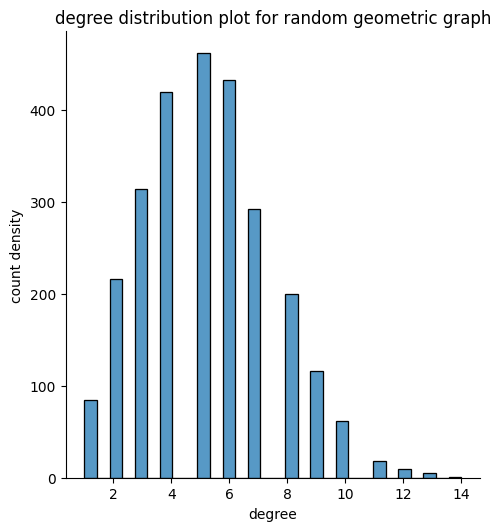

In [17]:
degrees_list = []
for run in simulation_run[0]['info_dict']:
    degrees_list.extend(run['degree_list'])

sns.displot(degrees_list)
plt.title("degree distribution plot for random geometric graph")
plt.xlabel("degree")
plt.ylabel("count density")

IRREVERSABLE GEOMETRIC GRAPH SIMULATION

simulation run for mean degree 5


100%|██████████| 30/30 [00:24<00:00,  1.20it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[{'average_degree': 5.82, 'num_nodes': 100, 'modality': 'reversable', 'degree_list': [13, 22, 6, 14, 33, 10, 7, 24, 15, 11, 6, 6, 17, 3, 8, 15, 16, 5, 9, 7, 5, 5, 4, 12, 4, 3, 6, 4, 8, 5, 6, 4, 4, 12, 3, 4, 6, 6, 6, 7, 3, 5, 5, 5, 4, 3, 7, 3, 4, 8, 5, 4, 6, 6, 3, 3, 4, 5, 3, 3, 3, 3, 5, 4, 3, 3, 3, 3, 3, 3, 3, 5, 3, 4, 3, 5, 3, 5, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'clustering_coefficient': 0.1584162222049051, 'degree_assortivity': -0.21747789576283041, 'mean_shortest_pathlength': 2.5545454545454547}, {'average_degree': 5.82, 'num_nodes': 100, 'modality': 'reversable', 'degree_list': [18, 15, 29, 8, 13, 19, 26, 13, 13, 4, 3, 10, 10, 6, 24, 11, 4, 7, 8, 8, 8, 12, 4, 8, 6, 3, 5, 4, 5, 7, 8, 6, 4, 6, 7, 3, 4, 4, 5, 3, 5, 3, 4, 3, 4, 4, 5, 4, 3, 4, 4, 6, 3, 5, 5, 3, 4, 5, 3, 3, 6, 3, 7, 3, 5, 3, 3, 3, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 5, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'clustering_coefficient': 0.15471483841112507, 'degree_assorti

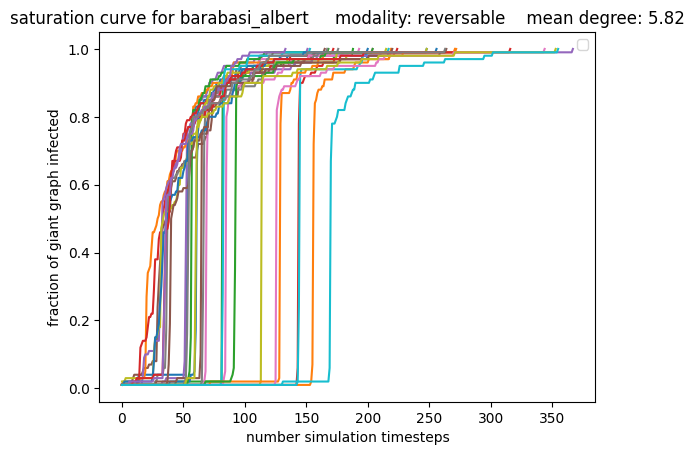

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[{'average_degree': 5.82, 'num_nodes': 100, 'modality': 'irreversable', 'degree_list': [13, 22, 6, 14, 33, 10, 7, 24, 15, 11, 6, 6, 17, 3, 8, 15, 16, 5, 9, 7, 5, 5, 4, 12, 4, 3, 6, 4, 8, 5, 6, 4, 4, 12, 3, 4, 6, 6, 6, 7, 3, 5, 5, 5, 4, 3, 7, 3, 4, 8, 5, 4, 6, 6, 3, 3, 4, 5, 3, 3, 3, 3, 5, 4, 3, 3, 3, 3, 3, 3, 3, 5, 3, 4, 3, 5, 3, 5, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'clustering_coefficient': 0.1584162222049051, 'degree_assortivity': -0.21747789576283041, 'mean_shortest_pathlength': 2.5545454545454547}, {'average_degree': 5.82, 'num_nodes': 100, 'modality': 'irreversable', 'degree_list': [18, 15, 29, 8, 13, 19, 26, 13, 13, 4, 3, 10, 10, 6, 24, 11, 4, 7, 8, 8, 8, 12, 4, 8, 6, 3, 5, 4, 5, 7, 8, 6, 4, 6, 7, 3, 4, 4, 5, 3, 5, 3, 4, 3, 4, 4, 5, 4, 3, 4, 4, 6, 3, 5, 5, 3, 4, 5, 3, 3, 6, 3, 7, 3, 5, 3, 3, 3, 5, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 5, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'clustering_coefficient': 0.15471483841112507, 'degree_ass

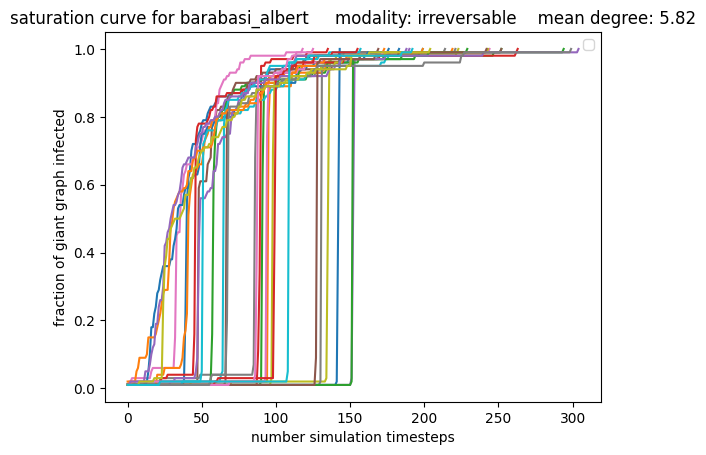

In [18]:
graph_name = "barabasi_albert"
for degree in geometric_graph_conf['mean_degrees']: 
    print(f"simulation run for mean degree {degree}")
    simulation_run = run_simulation(degree, graph_name)
    
    for mode in simulation_run: 
        print(mode['info_dict'][:5])
        plot_results(mode, graph_name)

Text(-3.6805555555555554, 0.5, 'count density')

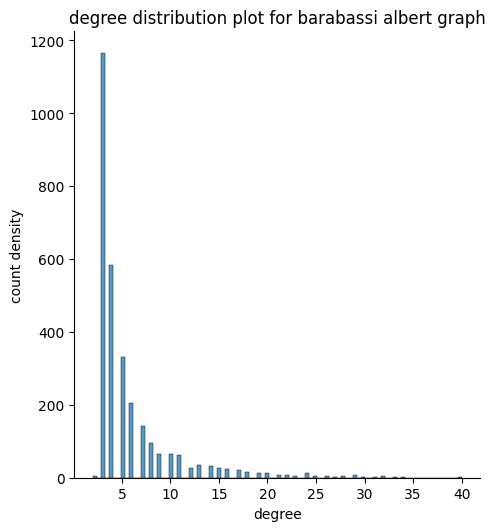

In [19]:
degrees_list = []
for run in simulation_run[0]['info_dict']:
    degrees_list.extend(run['degree_list'])

sns.displot(degrees_list)
plt.title("degree distribution plot for barabassi albert graph")
plt.xlabel("degree")
plt.ylabel("count density")

Results for reversable albert simulation 